In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('..')

This notebook is a guide for the neural networks based models of the library of the project "". :)

Météo-France, CNRS, CNRM, Centre d’Etudes de la Neige \
Léo Catteau, Spring 2025

### Contents:
* [MLP](#first-subbullet)
* [GRIN](#second-bullet)

All neural networks based models are trained following the same procedure implemented by the Filler. 

### MLP training <a class="anchor" id="first-bullet"></a>

In [2]:
from data_provider.data_provider import DataProvider
from models.linear_MLP import linear_MLP
from trainer.Filler import Filler

from types import SimpleNamespace

/Users/leocatteau/opt/anaconda3/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(
/Users/leocatteau/opt/anaconda3/lib/python3.9/site-packages/umap/plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(nopython=False)


In [3]:
data_kwargs = SimpleNamespace()
data_kwargs.data = 'bdclim_clean'
data_kwargs.dataset = 'SequenceMaskDataset'
data_kwargs.root_path = '../../datasets/'
data_kwargs.data_path = 'bdclim_safran_2023-2024.nc'
data_kwargs.has_predictors = False
data_kwargs.scaler = None
data_kwargs.batch_size = 10
data_kwargs.mask_length = 24*7*3
data_kwargs.mask_proba = 0.5

data_provider = DataProvider(data_kwargs)
train_dataloader = data_provider.train_dataloader()
test_dataloader = data_provider.test_dataloader()

model_kwargs = dict(seq_dim=data_provider.data.n_nodes)
filler_kwargs = SimpleNamespace()
filler_kwargs.lr = 1e-5
filler_kwargs.epochs = 100
filler_kwargs.keep_proba = 1-data_kwargs.mask_proba

filler = Filler(linear_MLP, model_kwargs, filler_kwargs)

In [4]:
train_loss, test_loss = filler.train(train_dataloader=train_dataloader, test_dataloader=test_dataloader, verbose=False)
filler.save_model('../trained_models/linear_MLP.pt')

 61%|██████    | 61/100 [00:59<00:37,  1.03it/s]

saturation


/var/folders/f4/yrwrg43j5sz8zr0l5s8m36qh0000gn/T/ipykernel_9569/376421635.py:5: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, np.max(train_loss)*1.1)


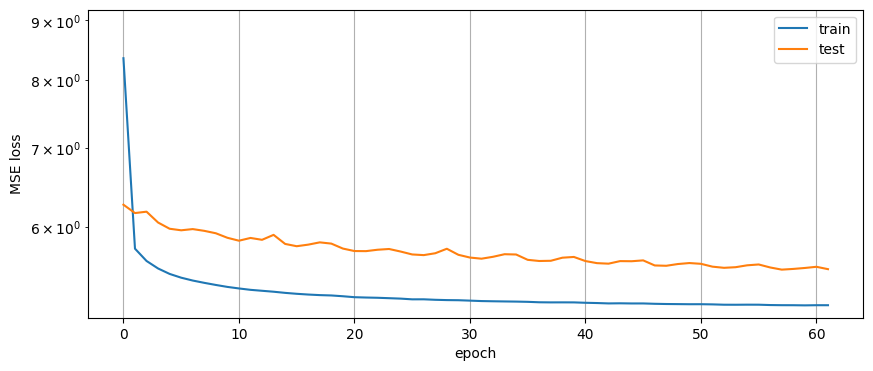

In [5]:
plt.figure(figsize=(10, 4))
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.yscale('log')
plt.ylim(0, np.max(train_loss)*1.1)
plt.xlabel('epoch')
plt.ylabel('MSE loss')
plt.grid()
plt.legend()
plt.show()

### GRIN <a class="anchor" id="second-bullet"></a>

In [6]:
from data_provider.data_provider import DataProvider
from models.GRIN import GRINet
from trainer.Filler import Filler

from types import SimpleNamespace

/Users/leocatteau/opt/anaconda3/lib/python3.9/site-packages/umap/plot.py:894: UserWarning: Hammer edge bundling is expensive for large graphs!
This may take a long time to compute!
  warn(


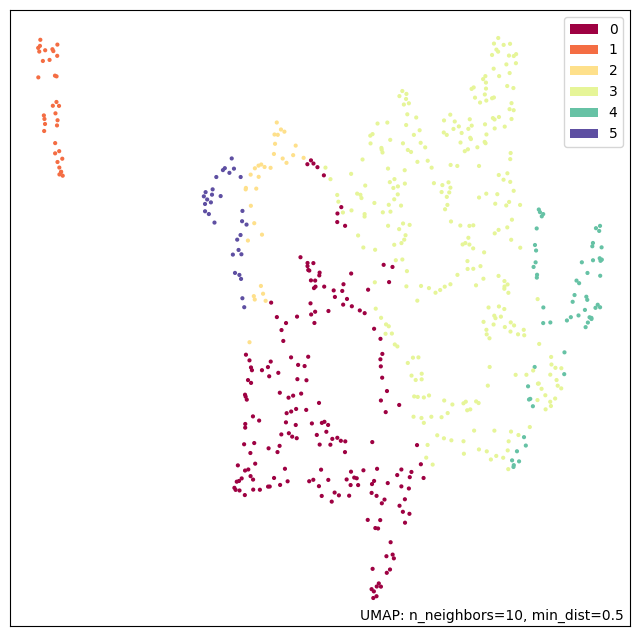

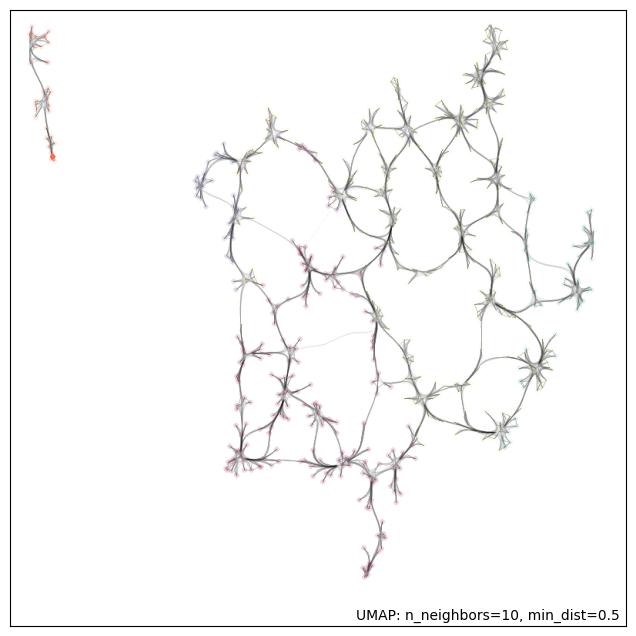

: 

In [ ]:
data_kwargs = SimpleNamespace()
data_kwargs.data = 'bdclim_clean'
data_kwargs.dataset = 'WindowHorizonDataset'
data_kwargs.root_path = '../../datasets/'
data_kwargs.data_path = 'bdclim_safran_2023-2024.nc'
data_kwargs.scaler = None
data_kwargs.batch_size = 10
data_kwargs.window = 24*7*1
data_kwargs.horizon = 0
data_kwargs.mask_proba = 0.5
data_kwargs.mask_length = 24*7*3

data_provider = DataProvider(data_kwargs)
adjacency_matrix = torch.FloatTensor(data_provider.data.umap_adjacency(threshold=0.1, verbose=True))
#adjacency_matrix = torch.FloatTensor(data_provider.data.correlation_adjacency())
train_dataloader = data_provider.train_dataloader()
test_dataloader = data_provider.test_dataloader()

model_kwargs = dict(adj=adjacency_matrix, d_in=1)
filler_kwargs = SimpleNamespace()
filler_kwargs.lr = 1e-5
filler_kwargs.epochs = 10
filler_kwargs.keep_proba = 1-data_kwargs.mask_proba

filler = Filler(GRINet, model_kwargs, filler_kwargs)

In [ ]:
train_loss, test_loss = filler.train(train_dataloader=train_dataloader, test_dataloader=test_dataloader, verbose=True)

  0%|          | 0/10 [00:00<?, ?it/s]/Users/leocatteau/Desktop/EPFL/Météo-France/code/Meteo-France/notebook_guides/../models/GRIN.py:152: UserWarning: where received a uint8 condition tensor. This behavior is deprecated and will be removed in a future version of PyTorch. Use a boolean condition instead. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorCompare.cpp:519.)
  x_s = torch.where(m_s, x_s, xs_hat_1)


In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.yscale('log')
plt.ylim(0, np.max(train_loss)*1.1)
plt.xlabel('epoch')
plt.ylabel('MSE loss')
plt.grid()
plt.legend()
plt.show()